<a href="https://colab.research.google.com/github/lituldust/fire-detection-and-tracking/blob/main/training_fire_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fire Detection and Tracking

## 1. Download Dataset

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lituldust","key":"261a3bfabf204e7a7740685aee629cc1"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download chrisfilo/firesense

Dataset URL: https://www.kaggle.com/datasets/chrisfilo/firesense
License(s): Attribution 4.0 International (CC BY 4.0)
 96% 754M/784M [00:07<00:00, 148MB/s]
100% 784M/784M [00:11<00:00, 74.6MB/s]


In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Ekstrak file zip dataset
import patoolib

patoolib.extract_archive('/content/firesense.zip')

INFO patool: Extracting /content/firesense.zip ...
INFO:patool:Extracting /content/firesense.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_mqpihxm6 -- /content/firesense.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_mqpihxm6 -- /content/firesense.zip
INFO patool: ... /content/firesense.zip extracted to `firesense' (multiple files in root).
INFO:patool:... /content/firesense.zip extracted to `firesense' (multiple files in root).


'firesense'

In [ ]:
import os
import glob

path = '/content/firesense'
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['smoke', 'fire']


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import glob
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle

# 2. Extract Dataset Frames

In [ ]:
def extract_frames(video_path, output_folder):
    """Extracts all frames from a video and saves them to an output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Could not open video {video_path}")
        return 0

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video: {os.path.basename(video_path)}, FPS: {fps:.2f}, Total frames: {frame_count}")

    saved_count = 0
    for i in tqdm(range(frame_count), desc=f"Extracting frames from {os.path.basename(video_path)}"):
        success, frame = video.read()
        if not success:
            print(f"Warning: Could not read frame {i} from {video_path}. Ending extraction.")
            break

        frame_filename = os.path.join(output_folder, f"frame_{saved_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        saved_count += 1

    video.release()
    print(f"Successfully extracted {saved_count} frames to {output_folder}")
    return saved_count

def process_videos(input_folder, output_base_folder):
    """Processes all videos in an input folder, extracting frames for each."""
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    video_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        print(f"No video files found in {input_folder}")
        return

    print(f"Found {len(video_files)} videos in {input_folder}.")

    for filename in video_files:
        video_name = os.path.splitext(filename)[0]
        video_path = os.path.join(input_folder, filename)

        # Create a unique folder for each video's frames
        # The folder name for frames will be the video name without extension
        output_folder_for_video = os.path.join(output_base_folder, video_name)

        print(f"\nProcessing video: {filename}")
        extract_frames(video_path, output_folder_for_video)

In [ ]:
# Define paths for video inputs and frame outputs
fire_videos_input_dir = '/content/firesense/fire/pos'
output_fire_frames_dir = '/content/firesense/frames/fire'

non_fire_videos_input_dir = '/content/firesense/fire/neg'
output_non_fire_frames_dir = '/content/firesense/frames/non_fire'

In [ ]:
if not os.path.exists(output_fire_frames_dir):
    os.makedirs(output_fire_frames_dir)
if not os.path.exists(output_non_fire_frames_dir):
    os.makedirs(output_non_fire_frames_dir)

In [ ]:
print("Starting frame extraction for FIRE videos...")
process_videos(fire_videos_input_dir, output_fire_frames_dir)

print("\nStarting frame extraction for NON-FIRE videos...")
process_videos(non_fire_videos_input_dir, output_non_fire_frames_dir)

print("\nFrame extraction complete.")

Starting frame extraction for FIRE videos...
Found 11 videos in /content/firesense/fire/pos.

Processing video: posVideo5.874.avi
Video: posVideo5.874.avi, FPS: 29.97, Total frames: 2406


Extracting frames from posVideo5.874.avi: 100%|██████████| 2406/2406 [00:07<00:00, 322.49it/s]


Successfully extracted 2406 frames to /content/firesense/frames/fire/posVideo5.874

Processing video: posVideo4.873.avi
Video: posVideo4.873.avi, FPS: 29.97, Total frames: 1655


Extracting frames from posVideo4.873.avi: 100%|██████████| 1655/1655 [00:06<00:00, 252.34it/s]


Successfully extracted 1655 frames to /content/firesense/frames/fire/posVideo4.873

Processing video: posVideo10.869.avi
Video: posVideo10.869.avi, FPS: 29.97, Total frames: 235


Extracting frames from posVideo10.869.avi: 100%|██████████| 235/235 [00:00<00:00, 317.27it/s]


Successfully extracted 235 frames to /content/firesense/frames/fire/posVideo10.869

Processing video: posVideo1.868.avi
Video: posVideo1.868.avi, FPS: 10.00, Total frames: 293


Extracting frames from posVideo1.868.avi: 100%|██████████| 293/293 [00:00<00:00, 348.29it/s]


Successfully extracted 293 frames to /content/firesense/frames/fire/posVideo1.868

Processing video: posVideo6.875.avi
Video: posVideo6.875.avi, FPS: 10.00, Total frames: 258


Extracting frames from posVideo6.875.avi: 100%|██████████| 258/258 [00:00<00:00, 380.07it/s]


Successfully extracted 258 frames to /content/firesense/frames/fire/posVideo6.875

Processing video: posVideo7.876.avi
Video: posVideo7.876.avi, FPS: 10.00, Total frames: 547


Extracting frames from posVideo7.876.avi: 100%|██████████| 547/547 [00:01<00:00, 481.91it/s]


Successfully extracted 547 frames to /content/firesense/frames/fire/posVideo7.876

Processing video: posVideo9.878.avi
Video: posVideo9.878.avi, FPS: 29.97, Total frames: 663


Extracting frames from posVideo9.878.avi: 100%|██████████| 663/663 [00:02<00:00, 289.84it/s]


Successfully extracted 663 frames to /content/firesense/frames/fire/posVideo9.878

Processing video: posVideo11.870.avi
Video: posVideo11.870.avi, FPS: 15.00, Total frames: 178


Extracting frames from posVideo11.870.avi: 100%|██████████| 178/178 [00:00<00:00, 320.49it/s]


Successfully extracted 178 frames to /content/firesense/frames/fire/posVideo11.870

Processing video: posVideo2.871.avi
Video: posVideo2.871.avi, FPS: 29.97, Total frames: 510


Extracting frames from posVideo2.871.avi: 100%|██████████| 510/510 [00:01<00:00, 309.75it/s]


Successfully extracted 510 frames to /content/firesense/frames/fire/posVideo2.871

Processing video: posVideo8.877.avi
Video: posVideo8.877.avi, FPS: 29.97, Total frames: 513


Extracting frames from posVideo8.877.avi: 100%|██████████| 513/513 [00:03<00:00, 150.41it/s]


Successfully extracted 513 frames to /content/firesense/frames/fire/posVideo8.877

Processing video: posVideo3.872.avi
Video: posVideo3.872.avi, FPS: 29.97, Total frames: 381


Extracting frames from posVideo3.872.avi: 100%|██████████| 381/381 [00:01<00:00, 291.48it/s]


Successfully extracted 381 frames to /content/firesense/frames/fire/posVideo3.872

Starting frame extraction for NON-FIRE videos...
Found 16 videos in /content/firesense/fire/neg.

Processing video: negsVideo3.860.avi
Video: negsVideo3.860.avi, FPS: 10.00, Total frames: 160


Extracting frames from negsVideo3.860.avi: 100%|██████████| 160/160 [00:00<00:00, 425.59it/s]


Successfully extracted 160 frames to /content/firesense/frames/non_fire/negsVideo3.860

Processing video: negsVideo11.1073.avi
Video: negsVideo11.1073.avi, FPS: 25.00, Total frames: 180


Extracting frames from negsVideo11.1073.avi: 100%|██████████| 180/180 [00:00<00:00, 1062.16it/s]


Successfully extracted 180 frames to /content/firesense/frames/non_fire/negsVideo11.1073

Processing video: negsVideo6.863.avi
Video: negsVideo6.863.avi, FPS: 25.00, Total frames: 1142


Extracting frames from negsVideo6.863.avi: 100%|██████████| 1142/1142 [00:03<00:00, 298.06it/s]


Successfully extracted 1142 frames to /content/firesense/frames/non_fire/negsVideo6.863

Processing video: negsVideo9.866.avi
Video: negsVideo9.866.avi, FPS: 25.00, Total frames: 645


Extracting frames from negsVideo9.866.avi: 100%|██████████| 645/645 [00:02<00:00, 297.33it/s]


Successfully extracted 645 frames to /content/firesense/frames/non_fire/negsVideo9.866

Processing video: negsVideo1.858.avi
Video: negsVideo1.858.avi, FPS: 24.00, Total frames: 4539


Extracting frames from negsVideo1.858.avi: 100%|██████████| 4539/4539 [00:20<00:00, 224.26it/s]


Successfully extracted 4539 frames to /content/firesense/frames/non_fire/negsVideo1.858

Processing video: negsVideo5.862.avi
Video: negsVideo5.862.avi, FPS: 30.00, Total frames: 439


Extracting frames from negsVideo5.862.avi: 100%|██████████| 439/439 [00:00<00:00, 498.55it/s]


Successfully extracted 439 frames to /content/firesense/frames/non_fire/negsVideo5.862

Processing video: negsVideo13.1075.avi
Video: negsVideo13.1075.avi, FPS: 24.46, Total frames: 271


Extracting frames from negsVideo13.1075.avi: 100%|██████████| 271/271 [00:00<00:00, 1009.92it/s]


Successfully extracted 271 frames to /content/firesense/frames/non_fire/negsVideo13.1075

Processing video: negsVideo2.859.avi
Video: negsVideo2.859.avi, FPS: 10.00, Total frames: 155


Extracting frames from negsVideo2.859.avi: 100%|██████████| 155/155 [00:00<00:00, 876.28it/s]


Successfully extracted 155 frames to /content/firesense/frames/non_fire/negsVideo2.859

Processing video: negsVideo8.865.avi
Video: negsVideo8.865.avi, FPS: 29.97, Total frames: 3761


Extracting frames from negsVideo8.865.avi: 100%|██████████| 3761/3761 [00:10<00:00, 371.91it/s]


Successfully extracted 3761 frames to /content/firesense/frames/non_fire/negsVideo8.865

Processing video: negsVideo10.1072.avi
Video: negsVideo10.1072.avi, FPS: 25.00, Total frames: 246


Extracting frames from negsVideo10.1072.avi: 100%|██████████| 246/246 [00:00<00:00, 1085.02it/s]


Successfully extracted 246 frames to /content/firesense/frames/non_fire/negsVideo10.1072

Processing video: negsVideo12.1074.avi
Video: negsVideo12.1074.avi, FPS: 19.69, Total frames: 514


Extracting frames from negsVideo12.1074.avi: 100%|██████████| 514/514 [00:08<00:00, 58.61it/s]


Successfully extracted 514 frames to /content/firesense/frames/non_fire/negsVideo12.1074

Processing video: negsVideo7.864.avi
Video: negsVideo7.864.avi, FPS: 30.00, Total frames: 541


Extracting frames from negsVideo7.864.avi: 100%|██████████| 541/541 [00:01<00:00, 300.48it/s]


Successfully extracted 541 frames to /content/firesense/frames/non_fire/negsVideo7.864

Processing video: negsVideo16.1077.avi
Video: negsVideo16.1077.avi, FPS: 18.51, Total frames: 196


Extracting frames from negsVideo16.1077.avi: 100%|██████████| 196/196 [00:04<00:00, 48.98it/s]


Successfully extracted 196 frames to /content/firesense/frames/non_fire/negsVideo16.1077

Processing video: negsVideo14.1076.avi
Video: negsVideo14.1076.avi, FPS: 24.06, Total frames: 45


Extracting frames from negsVideo14.1076.avi: 100%|██████████| 45/45 [00:00<00:00, 1096.95it/s]


Successfully extracted 45 frames to /content/firesense/frames/non_fire/negsVideo14.1076

Processing video: negsVideo4.861.avi
Video: negsVideo4.861.avi, FPS: 30.00, Total frames: 1931


Extracting frames from negsVideo4.861.avi: 100%|██████████| 1931/1931 [00:04<00:00, 404.08it/s]


Successfully extracted 1931 frames to /content/firesense/frames/non_fire/negsVideo4.861

Processing video: negsVideo15.1078.avi
Video: negsVideo15.1078.avi, FPS: 19.69, Total frames: 58


Extracting frames from negsVideo15.1078.avi: 100%|██████████| 58/58 [00:00<00:00, 77.01it/s]

Successfully extracted 58 frames to /content/firesense/frames/non_fire/negsVideo15.1078

Frame extraction complete.


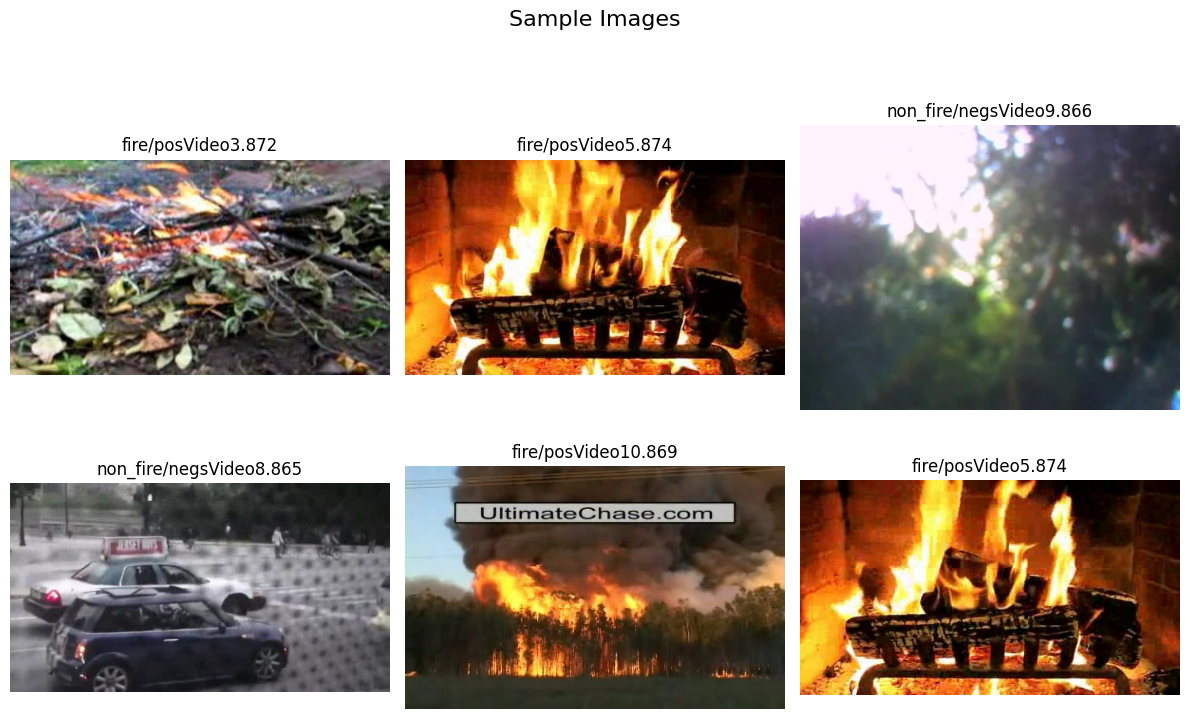

In [ ]:
def display_sample_images(base_folders, num_samples=6, title_prefix="Sample"):
    """Displays a random sample of images from the given folders."""
    sample_paths = []
    for folder_path in base_folders:
        # Search for .jpg files in subdirectories of folder_path
        pattern = os.path.join(folder_path, '**', '*.jpg') # '**' for recursive search
        sample_paths.extend(glob.glob(pattern, recursive=True))

    if not sample_paths:
        print("No images found to display. Ensure frames have been extracted and paths are correct.")
        return

    num_samples_to_show = min(num_samples, len(sample_paths))
    if num_samples_to_show == 0:
        print("No images available to sample.")
        return

    selected_image_paths = random.sample(sample_paths, num_samples_to_show)

    cols = 3
    rows = (num_samples_to_show + cols - 1) // cols
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, path in enumerate(selected_image_paths):
        try:
            img = Image.open(path)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis('off')
            # Title: parent_folder_name (fire/non_fire) / video_folder_name
            video_folder_name = os.path.basename(os.path.dirname(path))
            class_label = os.path.basename(os.path.dirname(os.path.dirname(path))) # fire or non_fire
            plt.title(f"{class_label}/{video_folder_name}")
        except Exception as e:
            print(f"Error loading image {path}: {e}")

    plt.suptitle(f"{title_prefix} Images", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

# Display samples (assuming frames are extracted)
display_sample_images([output_fire_frames_dir, output_non_fire_frames_dir], num_samples=6)

# 3. Preprocessing

In [ ]:
def preprocess_image(image_path, output_path, target_size=(224, 224)):
    try:
        # 1. Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Could not read image {image_path}. Skipping.")
            return

        # 2. Resize the image
        img_resized = cv2.resize(img, target_size)

        # 3. Blur the image
        img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)

        # (Optional) Further preprocessing steps can be added here, e.g.:
        # - Denoising
        # - Contrast enhancement

        # 5. Save the processed image (or you could return it)
        cv2.imwrite(output_path, img_blurred)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# --- Main script to iterate and preprocess all frames in nested folders ---
def process_all_frames_recursively(base_input_path, base_output_path, target_size=(224, 224)):
    """
    Recursively finds and preprocesses all images in the specified
    nested input directory structure.

    The expected input structure is:
    base_input_path/frames/<category_name>/<video_folder_name>/<frame_image>

    The output structure will be:
    base_output_path/<category_name>/<video_folder_name>/processed_<frame_image>

    Args:
        base_input_path (str): The root directory of the dataset (e.g., '/content/firesense/').
                               The script will look for a 'frames' subdirectory within this.
        base_output_path (str): The root directory where processed frames will be saved.
        target_size (tuple): Desired output size for images (width, height).
    """
    frames_source_root_dir = os.path.join(base_input_path, 'frames') # e.g., /content/firesense/frames/

    if not os.path.isdir(frames_source_root_dir):
        print(f"Error: Frames source directory not found: {frames_source_root_dir}")
        return

    # Ensure the main output directory exists
    os.makedirs(base_output_path, exist_ok=True)
    print(f"Created or found base output directory: {base_output_path}")

    print(f"\nStarting frame preprocessing...")
    print(f"Input frames will be read from subdirectories of: {frames_source_root_dir}")
    print(f"Processed frames will be saved to subdirectories of: {base_output_path}")
    print("-" * 50)

    total_files_processed = 0
    total_files_skipped = 0

    # 1. Iterate through category folders (e.g., 'fire', 'non_fire')
    for category_name in os.listdir(frames_source_root_dir):
        category_path = os.path.join(frames_source_root_dir, category_name)
        if not os.path.isdir(category_path):
            # print(f"Skipping non-directory item at category level: {category_name}")
            continue

        print(f"Processing Category: '{category_name}'")

        # Create corresponding category directory in output
        output_category_dir = os.path.join(base_output_path, category_name)
        os.makedirs(output_category_dir, exist_ok=True)

        # 2. Iterate through video folders (e.g., 'posVideo1.868')
        for video_folder_name in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder_name)
            if not os.path.isdir(video_folder_path):
                # print(f"  Skipping non-directory item at video folder level: {video_folder_name}")
                continue

            # print(f"  Processing Video Folder: '{video_folder_name}'") # Uncomment for more detail

            # Create corresponding video folder directory in output
            output_video_dir = os.path.join(output_category_dir, video_folder_name)
            os.makedirs(output_video_dir, exist_ok=True)

            frames_in_video_folder_count = 0
            # 3. Find and process image files in the current video folder
            for image_filename in os.listdir(video_folder_path):
                if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    input_image_full_path = os.path.join(video_folder_path, image_filename)

                    processed_filename = f"processed_{image_filename}"
                    output_image_full_path = os.path.join(output_video_dir, processed_filename)

                    # Call the user's preprocessing function
                    # Check if preprocess_image ran successfully (it doesn't return a status, so we assume success if no exception)
                    # We can also check if the output file was created.
                    initial_exception_count = 0 # A bit of a hack, ideally preprocess_image would return status
                    try:
                        preprocess_image(input_image_full_path, output_image_full_path, target_size)
                        if os.path.exists(output_image_full_path): # Check if file was actually created
                             total_files_processed += 1
                             frames_in_video_folder_count +=1
                        else:
                            # This case would be hit if preprocess_image returned due to img is None, but didn't save
                            print(f"    Notice: Output file not created for {input_image_full_path}, likely skipped in preprocess_image.")
                            total_files_skipped +=1

                    except Exception as e_main: # Catch any unexpected error from preprocess_image itself
                        print(f"    Main loop caught error processing {input_image_full_path}: {e_main}")
                        total_files_skipped += 1

            if frames_in_video_folder_count > 0:
                 print(f"  Processed {frames_in_video_folder_count} frames in video folder: '{video_folder_name}'")
            elif not any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in os.listdir(video_folder_path)):
                 print(f"  No image files found in video folder: '{video_folder_name}'")


        print("-" * 30) # Separator after processing each category

    print("\n" + "=" * 50)
    print("Frame preprocessing script finished.")
    print(f"Total files successfully processed: {total_files_processed}")
    print(f"Total files skipped or failed: {total_files_skipped}")
    print("=" * 50)

In [ ]:
# For Google Colab or typical Linux structure:
dataset_base_directory = '/content/firesense/'  # This should contain the 'frames' subdirectory
processed_frames_directory = '/content/processed_frames/'

# For local Windows machine, an example path might be:
# dataset_base_directory = 'C:/Users/YourUser/Desktop/firesense_dataset/'
# processed_frames_directory = 'C:/Users/YourUser/Desktop/processed_firesense_frames/'

image_target_size = (224, 224) # Standard size for many CNNs

process_all_frames_recursively(dataset_base_directory, processed_frames_directory, image_target_size)

# Split Dataset Folder

In [ ]:
base_frames_path = '/content/processed_frames/'
fire_frame_folders_path = os.path.join(base_frames_path, 'fire')
non_fire_frame_folders_path = os.path.join(base_frames_path, 'non_fire')

# Get paths to folders, where each folder contains frames from one video
fire_video_frame_folders = []
if os.path.exists(fire_frame_folders_path):
    fire_video_frame_folders = [os.path.join(fire_frame_folders_path, d) for d in os.listdir(fire_frame_folders_path) if os.path.isdir(os.path.join(fire_frame_folders_path, d))]
else:
    print(f"Warning: Fire frame directory not found: {fire_frame_folders_path}")

non_fire_video_frame_folders = []
if os.path.exists(non_fire_frame_folders_path):
    non_fire_video_frame_folders = [os.path.join(non_fire_frame_folders_path, d) for d in os.listdir(non_fire_frame_folders_path) if os.path.isdir(os.path.join(non_fire_frame_folders_path, d))]
else:
    print(f"Warning: Non-fire frame directory not found: {non_fire_frame_folders_path}")

if not fire_video_frame_folders and not non_fire_video_frame_folders:
    raise FileNotFoundError("No video frame folders found. Ensure frames are extracted correctly into subdirectories under /content/Dataset/frames/fire/ and /content/Dataset/frames/non_fire/")

# Shuffle for randomness before splitting
random.shuffle(fire_video_frame_folders)
random.shuffle(non_fire_video_frame_folders)

train_ratio = 0.7

num_fire_train = int(len(fire_video_frame_folders) * train_ratio)
fire_train_folders = fire_video_frame_folders[:num_fire_train]
fire_test_folders = fire_video_frame_folders[num_fire_train:]

num_non_fire_train = int(len(non_fire_video_frame_folders) * train_ratio)
non_fire_train_folders = non_fire_video_frame_folders[:num_non_fire_train]
non_fire_test_folders = non_fire_video_frame_folders[num_non_fire_train:]

# These lists contain paths to folders of frames
train_video_folders = fire_train_folders + non_fire_train_folders
test_video_folders = fire_test_folders + non_fire_test_folders

random.shuffle(train_video_folders) # Shuffle combined list
random.shuffle(test_video_folders)  # Shuffle combined list

print(f"Total fire video folders: {len(fire_video_frame_folders)}")
print(f"Total non-fire video folders: {len(non_fire_video_frame_folders)}")
print(f"Training video folders: {len(train_video_folders)} ({len(fire_train_folders)} fire, {len(non_fire_train_folders)} non-fire)")
print(f"Testing video folders: {len(test_video_folders)} ({len(fire_test_folders)} fire, {len(non_fire_test_folders)} non-fire)")

Total fire video folders: 11
Total non-fire video folders: 16
Training video folders: 18 (7 fire, 11 non-fire)
Testing video folders: 9 (4 fire, 5 non-fire)


In [ ]:
print(train_video_folders)

['/content/processed_frames/non_fire/negsVideo8.865', '/content/processed_frames/fire/posVideo2.871', '/content/processed_frames/non_fire/negsVideo4.861', '/content/processed_frames/non_fire/negsVideo13.1075', '/content/processed_frames/fire/posVideo8.877', '/content/processed_frames/non_fire/negsVideo12.1074', '/content/processed_frames/non_fire/negsVideo7.864', '/content/processed_frames/non_fire/negsVideo9.866', '/content/processed_frames/fire/posVideo11.870', '/content/processed_frames/non_fire/negsVideo5.862', '/content/processed_frames/non_fire/negsVideo11.1073', '/content/processed_frames/fire/posVideo5.874', '/content/processed_frames/non_fire/negsVideo6.863', '/content/processed_frames/fire/posVideo3.872', '/content/processed_frames/non_fire/negsVideo15.1078', '/content/processed_frames/fire/posVideo7.876', '/content/processed_frames/fire/posVideo9.878', '/content/processed_frames/non_fire/negsVideo3.860']


In [ ]:
print(non_fire_train_folders)

['/content/processed_frames/non_fire/negsVideo7.864', '/content/processed_frames/non_fire/negsVideo15.1078', '/content/processed_frames/non_fire/negsVideo4.861', '/content/processed_frames/non_fire/negsVideo5.862', '/content/processed_frames/non_fire/negsVideo9.866', '/content/processed_frames/non_fire/negsVideo11.1073', '/content/processed_frames/non_fire/negsVideo3.860', '/content/processed_frames/non_fire/negsVideo8.865', '/content/processed_frames/non_fire/negsVideo13.1075', '/content/processed_frames/non_fire/negsVideo12.1074', '/content/processed_frames/non_fire/negsVideo6.863']


In [ ]:
print(test_video_folders)

['/content/processed_frames/fire/posVideo4.873', '/content/processed_frames/non_fire/negsVideo14.1076', '/content/processed_frames/fire/posVideo6.875', '/content/processed_frames/non_fire/negsVideo1.858', '/content/processed_frames/fire/posVideo10.869', '/content/processed_frames/non_fire/negsVideo2.859', '/content/processed_frames/non_fire/negsVideo16.1077', '/content/processed_frames/fire/posVideo1.868', '/content/processed_frames/non_fire/negsVideo10.1072']


In [ ]:
print(non_fire_test_folders)

['/content/processed_frames/non_fire/negsVideo2.859', '/content/processed_frames/non_fire/negsVideo16.1077', '/content/processed_frames/non_fire/negsVideo10.1072', '/content/processed_frames/non_fire/negsVideo1.858', '/content/processed_frames/non_fire/negsVideo14.1076']


# 5. Feature Extraction

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops

def extract_image_features(pil_image, previous_pil_image=None, img_size=(128, 128), hof_nbins=8):
    # --- Common Image Preparation ---
    img_resized_pil = pil_image.resize(img_size)
    current_img_np_rgb = np.array(img_resized_pil)

    # --- HSV Color Histograms (16 bins per channel) ---
    hsv_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv_img], [0], None, [16], [0, 180]) # Hue range is 0-179
    hist_s = cv2.calcHist([hsv_img], [1], None, [16], [0, 256])
    hist_v = cv2.calcHist([hsv_img], [2], None, [16], [0, 256])

    cv2.normalize(hist_h, hist_h, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_s, hist_s, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_v, hist_v, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    hsv_color_features = np.concatenate((hist_h, hist_s, hist_v)).flatten()

    # --- YCrCb Color Histograms (16 bins per channel) ---
    ycrcb_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2YCrCb)
    hist_y = cv2.calcHist([ycrcb_img], [0], None, [16], [0, 256])
    hist_cr = cv2.calcHist([ycrcb_img], [1], None, [16], [0, 256])
    hist_cb = cv2.calcHist([ycrcb_img], [2], None, [16], [0, 256])

    cv2.normalize(hist_y, hist_y, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_cr, hist_cr, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_cb, hist_cb, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    ycrcb_color_features = np.concatenate((hist_y, hist_cr, hist_cb)).flatten()

    # --- LBP Texture Features ---
    gray_img = cv2.cvtColor(current_img_np_rgb, cv2.COLOR_RGB2GRAY)
    radius = 1  # LBP radius
    n_points = 8 * radius  # Number of points to consider for LBP

    lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
    # Calculate histogram of LBP
    # For 'uniform' LBP, the number of bins is n_points + 2
    lbp_hist, _ = np.histogram(lbp.ravel(),
                               bins=np.arange(0, n_points + 3), # n_points + 2 bins
                               range=(0, n_points + 2))
    # Normalize LBP histogram
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Add epsilon to avoid division by zero
    lbp_texture_features = lbp_hist.flatten()

    # --- GLCM Texture Features ---
    # gray_img is already computed from current_img_np_rgb
    glcm = graycomatrix(gray_img, distances=[5], angles=[0],
                        levels=256, symmetric=True, normed=True)

    glcm_features_list = []
    props_to_extract = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props_to_extract:
        val = graycoprops(glcm, prop)[0, 0]
        glcm_features_list.append(val)
    glcm_texture_features = np.array(glcm_features_list).flatten()

    # --- Histogram of Optical Flow (HOF) Features ---
    hof_features_val = np.zeros(hof_nbins) # Initialize with zeros
    if previous_pil_image is not None:
        previous_img_resized_pil = previous_pil_image.resize(img_size)
        previous_img_np_rgb = np.array(previous_img_resized_pil)

        prev_gray = cv2.cvtColor(previous_img_np_rgb, cv2.COLOR_RGB2GRAY)
        curr_gray = gray_img # Already computed from current_img_np_rgb

        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray,
                                            None, 0.5, 3, 15, 3, 5, 1.2, 0)

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

        # `np.histogram` bin edges should be `nbins + 1`
        bin_edges = np.linspace(0, 360, hof_nbins + 1)
        hof_hist, _ = np.histogram(ang.ravel(), bins=bin_edges, weights=mag.ravel(), density=True)

        hof_hist = np.nan_to_num(hof_hist) # Handle potential NaN/inf from zero magnitude areas
        hof_features_val = hof_hist.flatten()
    else:
        # This print can be verbose if called many times, consider removing or logging differently
        # print("Note: No previous image provided, HOF features set to zeros.")
        pass


    # --- Concatenate all features ---
    features = np.concatenate((
        hsv_color_features,       # 48 features (16*3)
        ycrcb_color_features,     # 48 features (16*3)
        lbp_texture_features,     # 10 features (8 points + 2 for uniform LBP)
        glcm_texture_features,    # 6 features
        hof_features_val          # hof_nbins features (default 8)
    ))
    return features

# --- Test the updated feature extraction ---
# Ensure 'train_video_folders' is defined and points to folders with JPGs if using this part
if 'train_video_folders' in locals() and isinstance(train_video_folders, list) and len(train_video_folders) > 0:
    image_files = glob.glob(os.path.join(train_video_folders[0], '*.jpg'))
    if len(image_files) > 1:
        sample_img_path_curr = image_files[0]
        sample_img_path_prev = image_files[1] # Need a second image for HOF test

        pil_curr = Image.open(sample_img_path_curr).convert('RGB')
        pil_prev = Image.open(sample_img_path_prev).convert('RGB')

        print("\n--- Testing with actual images from dataset ---")
        actual_features = extract_image_features(pil_curr, previous_pil_image=pil_prev)
        print(f"Actual image feature vector shape: {actual_features.shape}")
        # Expected: 48 (HSV) + 48 (YCrCb) + 10 (LBP) + 6 (GLCM) + 8 (HOF) = 120
    elif len(image_files) > 0:
        sample_img_path_curr = image_files[0]
        pil_curr = Image.open(sample_img_path_curr).convert('RGB')
        print("\n--- Testing with one actual image from dataset (HOF will be zeros) ---")
        actual_features_single = extract_image_features(pil_curr)
        print(f"Actual single image feature vector shape: {actual_features_single.shape}")
    else:
        print("\nCannot test with actual images: Not enough images found in the first training folder.")
else:
    print("\nSkipping test with actual images: 'train_video_folders' not defined or empty.")


--- Testing with actual images from dataset ---
Actual image feature vector shape: (120,)


In [ ]:
def create_dataset_from_folders(list_of_video_folders, feature_extractor_fn):
    """
    Loads all images from the given video folders, extracts features, and assigns labels.
    Each path in list_of_video_folders is a directory containing frames of one video.
    The label ('fire' or 'non_fire') is derived from the parent directory of these video_folders.
    Example: /content/Dataset/frames/fire/video1_frames -> label 'fire'
    """
    all_features = []
    all_labels = [] # Store string labels first for clarity, then encode

    for video_frames_folder in tqdm(list_of_video_folders, desc="Processing video folders"):
        # Determine label from the parent directory name ('fire' or 'non_fire')
        class_label_str = os.path.basename(os.path.dirname(video_frames_folder)) # 'fire' or 'non_fire'

        image_file_paths = glob.glob(os.path.join(video_frames_folder, '*.jpg'))
        if not image_file_paths:
            print(f"Warning: No .jpg images found in {video_frames_folder}")
            continue

        for img_path in image_file_paths:
            try:
                pil_img = Image.open(img_path).convert('RGB') # Ensure RGB format
                features = feature_extractor_fn(pil_img)
                all_features.append(features)
                all_labels.append(class_label_str)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(all_features), np.array(all_labels)

print("Preparing training dataset...")
X_train_raw, y_train_str = create_dataset_from_folders(train_video_folders, extract_image_features)

print("\nPreparing testing dataset...")
X_test_raw, y_test_str = create_dataset_from_folders(test_video_folders, extract_image_features)

if X_train_raw.shape[0] == 0 or X_test_raw.shape[0] == 0:
    raise ValueError("Training or testing set is empty. Please check frame extraction and paths.")

print(f"\nRaw training features shape: {X_train_raw.shape}")
print(f"Raw training labels shape: {y_train_str.shape}")
print(f"Raw testing features shape: {X_test_raw.shape}")
print(f"Raw testing labels shape: {y_test_str.shape}")

Preparing training dataset...


Processing video folders: 100%|██████████| 18/18 [02:25<00:00,  8.06s/it]



Preparing testing dataset...


Processing video folders: 100%|██████████| 9/9 [01:14<00:00,  8.32s/it]


Raw training features shape: (14840, 120)
Raw training labels shape: (14840,)
Raw testing features shape: (7622, 120)
Raw testing labels shape: (7622,)


In [ ]:
# Manual Label Encoding: 'fire' -> 1, 'non_fire' -> 0
print("\nApplying manual label encoding:")
print("fire -> 1")
print("non_fire -> 0")

target_map = {'fire': 1, 'non_fire': 0}

unknown_labels_train = set(y_train_str) - set(target_map.keys())
if unknown_labels_train:
    raise ValueError(f"Unknown labels found in training string labels: {unknown_labels_train}. Expected only 'fire' or 'non_fire'.")
unknown_labels_test = set(y_test_str) - set(target_map.keys())
if unknown_labels_test:
    raise ValueError(f"Unknown labels found in test string labels: {unknown_labels_test}. Expected only 'fire' or 'non_fire'.")

y_train_numeric = np.array([target_map[label] for label in y_train_str]) # Renamed to avoid confusion before SMOTE
y_test = np.array([target_map[label] for label in y_test_str]) # y_test remains unchanged

print(f"\nOriginal training labels distribution (0: non-fire, 1: fire): {np.unique(y_train_numeric, return_counts=True)}")
print(f"Testing labels distribution (0: non-fire, 1: fire): {np.unique(y_test, return_counts=True)}")

# --- NEW: Apply SMOTE to the training data (X_train_raw, y_train_numeric) ---
# Ensure X_train_raw has samples before applying SMOTE
if X_train_raw.shape[0] > 0:
    from imblearn.over_sampling import SMOTE # Make sure to install imblearn: pip install imbalanced-learn

    # Check if there's a minority class to oversample (at least 2 classes and one is minority)
    unique_classes, counts = np.unique(y_train_numeric, return_counts=True)
    if len(unique_classes) > 1 and np.min(counts) > 0: # SMOTE needs at least one sample in minority class
        # k_neighbors for SMOTE must be less than the number of samples in the smallest class
        min_class_count = np.min(counts)
        smote_k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

        if smote_k_neighbors > 0:
            print(f"\nApplying SMOTE to training data with k_neighbors={smote_k_neighbors}...")
            smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_numeric)
            print(f"Shape of X_train_raw before SMOTE: {X_train_raw.shape}, y_train_numeric: {y_train_numeric.shape}")
            print(f"Shape of X_train after SMOTE: {X_train_resampled.shape}, y_train: {y_train_resampled.shape}")
            print(f"Resampled training labels distribution: {np.unique(y_train_resampled, return_counts=True)}")
            X_train_processed = X_train_resampled # Use resampled data for scaling
            y_train = y_train_resampled         # Use resampled labels
        else:
            print("SMOTE not applied: minority class has too few samples for k_neighbors.")
            X_train_processed = X_train_raw
            y_train = y_train_numeric
    else:
        print("SMOTE not applied: not enough classes or samples in minority class.")
        X_train_processed = X_train_raw
        y_train = y_train_numeric
else:
    print("SMOTE not applied: X_train_raw is empty.")
    X_train_processed = X_train_raw # Should be empty
    y_train = y_train_numeric       # Should be empty

# Scale features (use X_train_processed which is X_train_raw or X_train_resampled)
scaler = StandardScaler()
if X_train_processed.shape[0] > 0: # Only fit scaler if there's data
    X_train = scaler.fit_transform(X_train_processed)
else:
    X_train = X_train_processed # empty array

# Transform X_test using the same scaler (fitted on training data)
# Ensure X_test_raw is not empty before transforming
if X_test_raw.shape[0] > 0:
    X_test = scaler.transform(X_test_raw)
else:
    X_test = X_test_raw # empty array


print(f"\nProcessed training features shape: {X_train.shape}")
print(f"Processed training labels shape: {y_train.shape}")
print(f"Processed testing features shape: {X_test.shape}")
print(f"Processed testing labels shape: {y_test.shape}")


Applying manual label encoding:
fire -> 1
non_fire -> 0

Original training labels distribution (0: non-fire, 1: fire): (array([0, 1]), array([9642, 5198]))
Testing labels distribution (0: non-fire, 1: fire): (array([0, 1]), array([5181, 2441]))

Applying SMOTE to training data with k_neighbors=5...
Shape of X_train_raw before SMOTE: (14840, 120), y_train_numeric: (14840,)
Shape of X_train after SMOTE: (19284, 120), y_train: (19284,)
Resampled training labels distribution: (array([0, 1]), array([9642, 9642]))

Processed training features shape: (19284, 120)
Processed training labels shape: (19284,)
Processed testing features shape: (7622, 120)
Processed testing labels shape: (7622,)


Training data for models: 9642 fire samples (label 1), 9642 non-fire samples (label 0).

Starting model training and hyperparameter tuning...

--- Training LogisticRegression ---
Performing GridSearchCV for LogisticRegression...
Fitting 3 folds for each of 14 candidates, totalling 42 fits

Best parameters for LogisticRegression:
{'C': 0.001, 'solver': 'liblinear'}
Best F1-score (fire class) for LogisticRegression on cross-validation: 0.9396

--- Evaluating LogisticRegression on the Test Set ---
Accuracy for LogisticRegression on Test Set: 0.4289

Classification Report for LogisticRegression on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.59      0.53      0.56      5181
    fire (1)       0.17      0.21      0.19      2441

    accuracy                           0.43      7622
   macro avg       0.38      0.37      0.37      7622
weighted avg       0.46      0.43      0.44      7622

ROC AUC for LogisticRegression on Test Set: 0.4234

Confusion 

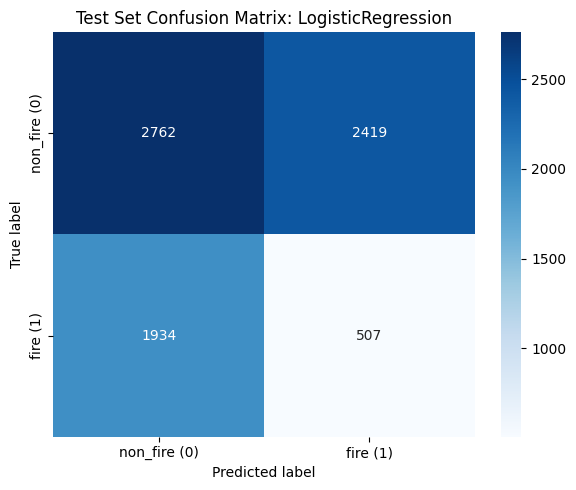

--------------------------------------------------
--- Training RandomForest ---
Performing GridSearchCV for RandomForest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters for RandomForest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best F1-score (fire class) for RandomForest on cross-validation: 0.9458

--- Evaluating RandomForest on the Test Set ---
Accuracy for RandomForest on Test Set: 0.6462

Classification Report for RandomForest on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.68      0.91      0.78      5181
    fire (1)       0.32      0.09      0.14      2441

    accuracy                           0.65      7622
   macro avg       0.50      0.50      0.46      7622
weighted avg       0.56      0.65      0.57      7622

ROC AUC for RandomForest on Test Set: 0.7626

Confusion Matrix for RandomForest on Test Set:


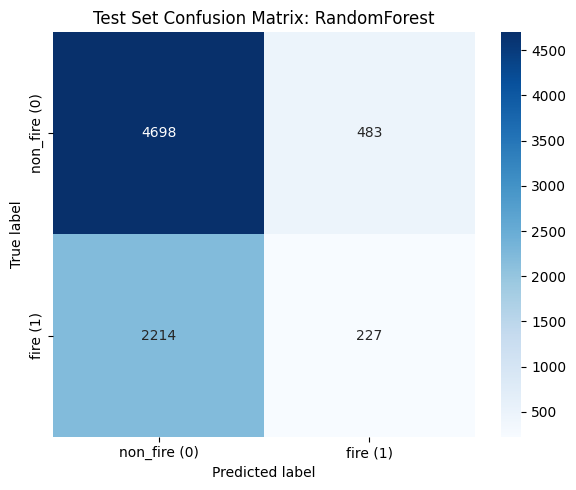

--------------------------------------------------
--- Training SVC ---
Performing GridSearchCV for SVC...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best parameters for SVC:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best F1-score (fire class) for SVC on cross-validation: 0.9186

--- Evaluating SVC on the Test Set ---
Accuracy for SVC on Test Set: 0.7052

Classification Report for SVC on Test Set:
              precision    recall  f1-score   support

non_fire (0)       0.79      0.77      0.78      5181
    fire (1)       0.54      0.56      0.55      2441

    accuracy                           0.71      7622
   macro avg       0.66      0.67      0.66      7622
weighted avg       0.71      0.71      0.71      7622

ROC AUC for SVC on Test Set: 0.7105

Confusion Matrix for SVC on Test Set:


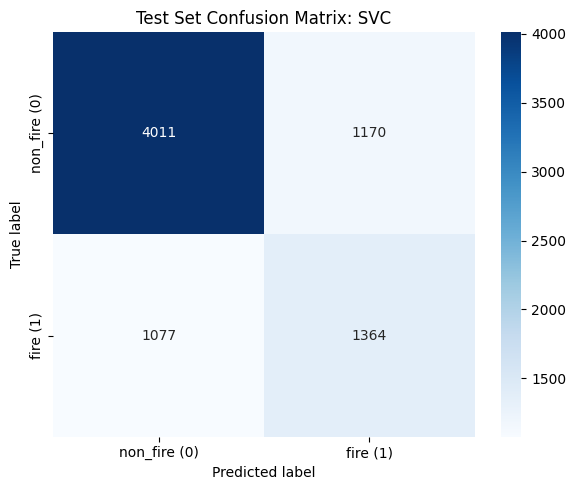

--------------------------------------------------

--- Overall Best Model (based on CV F1-score for fire class) ---
Model: RandomForest
Cross-validation F1-score (fire class): 0.9458
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [ ]:
# (Previous parts of your script: imports, data loading, X_train/y_train checks, models_to_train definition, etc.)

if 'X_train' not in locals() or X_train.shape[0] < 1:
    print("Training data (X_train) is not available or empty. Please run previous cells.")
else:
    fire_count = np.sum(y_train == 1)
    non_fire_count = np.sum(y_train == 0)
    print(f"Training data for models: {fire_count} fire samples (label 1), {non_fire_count} non-fire samples (label 0).")

    f1_scorer_fire = make_scorer(f1_score, pos_label=1, zero_division=0)

    models_to_train = {
        "LogisticRegression": (
            LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000),
            {
                'C': [0.001, 0.01, 0.1, 1, 10, 50, 100],
                'solver': ['liblinear', 'saga']
            }
        ),
        "RandomForest": (
            RandomForestClassifier(random_state=42, class_weight='balanced'),
            {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        ),
        "SVC": (
            SVC(random_state=42, class_weight='balanced', probability=True), # Ensure probability=True for SVC
            {
                'C': [0.1, 1, 10, 50],
                'gamma': ['scale', 'auto', 0.01, 0.001],
                'kernel': ['rbf', 'linear']
            }
        )
    }

    trained_models_info = {}
    print("\nStarting model training and hyperparameter tuning...\n")

    for model_name, (model_instance, param_grid) in models_to_train.items():
        print(f"--- Training {model_name} ---")
        grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid,
                                   cv=3, n_jobs=-1, verbose=1, scoring=f1_scorer_fire)

        print(f"Performing GridSearchCV for {model_name}...")
        grid_search.fit(X_train, y_train)

        best_estimator = grid_search.best_estimator_
        best_cv_score = grid_search.best_score_ # This is F1 for fire

        trained_models_info[model_name] = {
            'model': best_estimator,
            'cv_f1_fire': best_cv_score, # Store CV F1 for fire
            'best_params': grid_search.best_params_,
            'test_accuracy': None,
            'test_f1_fire': None,
            'test_precision_fire': None,
            'test_recall_fire': None,
            'test_roc_auc': None,
            'test_fpr': None,
            'test_tpr': None
        }

        print(f"\nBest parameters for {model_name}:")
        print(grid_search.best_params_)
        print(f"Best F1-score (fire class) for {model_name} on cross-validation: {best_cv_score:.4f}")

        print(f"\n--- Evaluating {model_name} on the Test Set ---")
        if 'X_test' in locals() and X_test.shape[0] > 0:
            y_pred_test = best_estimator.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred_test)
            trained_models_info[model_name]['test_accuracy'] = accuracy_test
            print(f"Accuracy for {model_name} on Test Set: {accuracy_test:.4f}")

            print(f"\nClassification Report for {model_name} on Test Set:")
            target_names_report = ['non_fire (0)', 'fire (1)']
            report_dict = classification_report(y_test, y_pred_test, target_names=target_names_report, zero_division=0, output_dict=True)
            print(classification_report(y_test, y_pred_test, target_names=target_names_report, zero_division=0))

            # Store specific metrics from the report
            if 'fire (1)' in report_dict:
                trained_models_info[model_name]['test_f1_fire'] = report_dict['fire (1)']['f1-score']
                trained_models_info[model_name]['test_precision_fire'] = report_dict['fire (1)']['precision']
                trained_models_info[model_name]['test_recall_fire'] = report_dict['fire (1)']['recall']
            else: # Handle cases where a class might not be predicted (unlikely with balanced weights but good practice)
                 trained_models_info[model_name]['test_f1_fire'] = 0.0
                 trained_models_info[model_name]['test_precision_fire'] = 0.0
                 trained_models_info[model_name]['test_recall_fire'] = 0.0


            # ROC Curve and AUC
            if hasattr(best_estimator, "predict_proba"):
                y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test, pos_label=1)
                roc_auc = auc(fpr, tpr)
                trained_models_info[model_name]['test_roc_auc'] = roc_auc
                trained_models_info[model_name]['test_fpr'] = fpr
                trained_models_info[model_name]['test_tpr'] = tpr
                print(f"ROC AUC for {model_name} on Test Set: {roc_auc:.4f}")
            else:
                print(f"{model_name} does not support predict_proba, skipping ROC AUC.")


            print(f"\nConfusion Matrix for {model_name} on Test Set:")
            cm_test = confusion_matrix(y_test, y_pred_test, labels=[0,1])
            plt.figure(figsize=(6,5))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap=plt.cm.Blues,
                        xticklabels=target_names_report, yticklabels=target_names_report)
            plt.title(f'Test Set Confusion Matrix: {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping test set evaluation for {model_name} as X_test is empty or not defined.")
        print("-" * 50)

    # --- Determine the overall best model (your existing logic) ---
    best_model_name_overall = None
    best_model_instance_overall = None
    highest_cv_f1_score = -1

    if trained_models_info:
        for model_name_iter, info in trained_models_info.items(): # Renamed model_name to avoid conflict
            if info['cv_f1_fire'] is not None and info['cv_f1_fire'] > highest_cv_f1_score:
                highest_cv_f1_score = info['cv_f1_fire']
                best_model_name_overall = model_name_iter
                best_model_instance_overall = info['model']

        if best_model_name_overall:
            print(f"\n--- Overall Best Model (based on CV F1-score for fire class) ---")
            print(f"Model: {best_model_name_overall}")
            print(f"Cross-validation F1-score (fire class): {highest_cv_f1_score:.4f}")
            print(f"Best Parameters: {trained_models_info[best_model_name_overall]['best_params']}")
        else:
            print("\nNo models had a valid CV F1 score to determine an overall best.")
    else:
        print("\nNo models were trained.")

# --- Add Visualization Code Below This Line ---



--- Comparative Performance Visualizations ---


<ipython-input-37-8d88a8a16876>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=cv_f1_scores, palette="viridis")


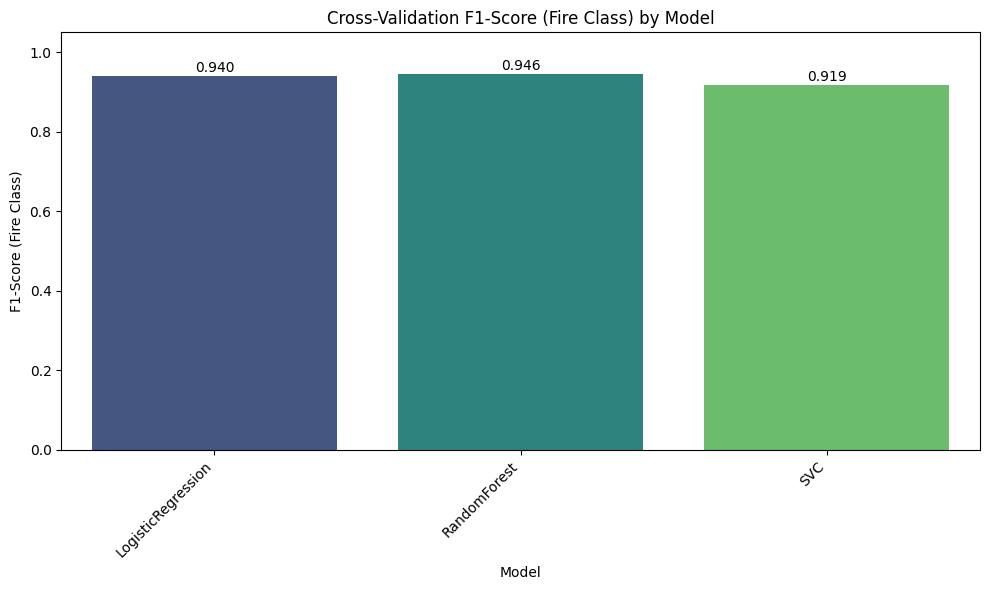

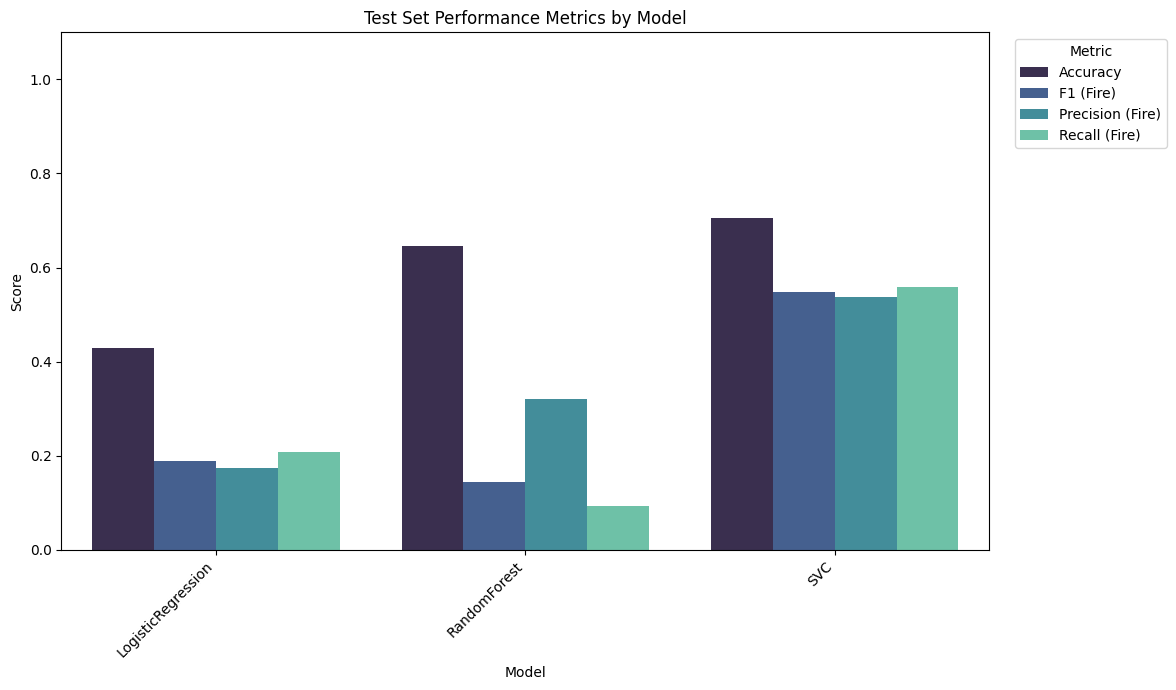

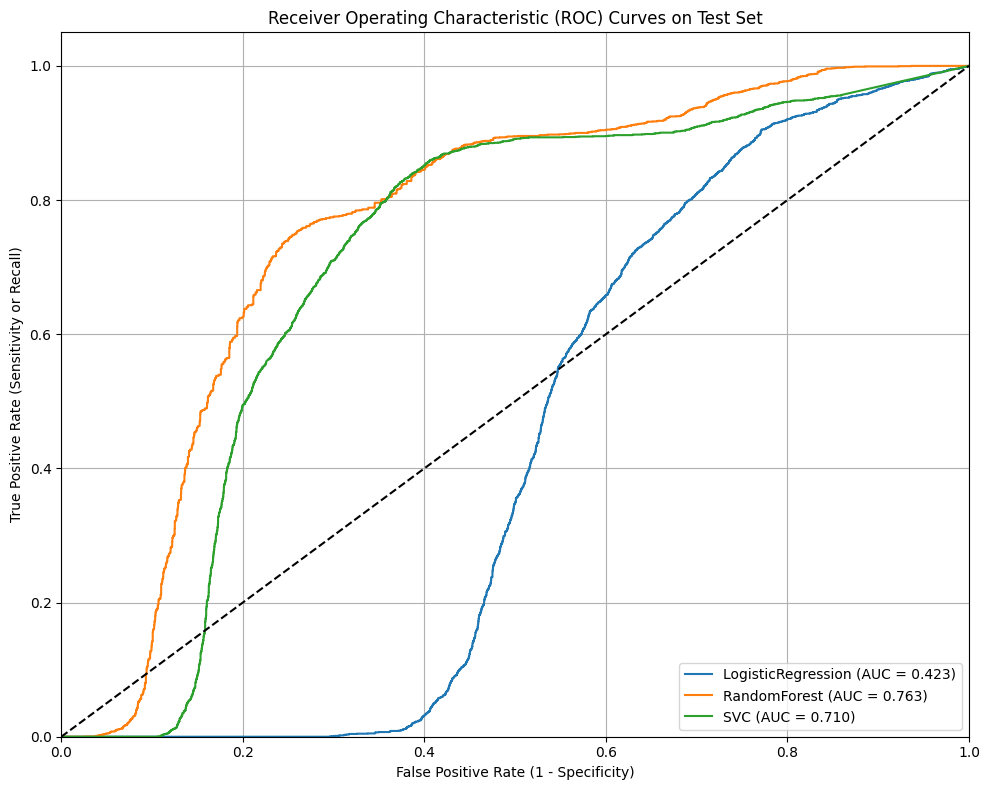

In [ ]:
if trained_models_info and ('X_test' in locals() and X_test.shape[0] > 0): # Check if models were trained and test data exists
    print("\n\n--- Comparative Performance Visualizations ---")

    model_names = list(trained_models_info.keys())

    # Data for plots
    cv_f1_scores = [trained_models_info[m]['cv_f1_fire'] if trained_models_info[m]['cv_f1_fire'] is not None else 0 for m in model_names]
    test_f1_scores_fire = [trained_models_info[m]['test_f1_fire'] if trained_models_info[m]['test_f1_fire'] is not None else 0 for m in model_names]
    test_accuracies = [trained_models_info[m]['test_accuracy'] if trained_models_info[m]['test_accuracy'] is not None else 0 for m in model_names]
    test_precision_fire = [trained_models_info[m]['test_precision_fire'] if trained_models_info[m]['test_precision_fire'] is not None else 0 for m in model_names]
    test_recall_fire = [trained_models_info[m]['test_recall_fire'] if trained_models_info[m]['test_recall_fire'] is not None else 0 for m in model_names]

    # 1. Bar Chart: CV F1-Scores (Fire Class)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=cv_f1_scores, palette="viridis")
    plt.title('Cross-Validation F1-Score (Fire Class) by Model')
    plt.xlabel('Model')
    plt.ylabel('F1-Score (Fire Class)')
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.05)
    for i, v in enumerate(cv_f1_scores):
        plt.text(i, v + 0.01, f"{v:.3f}", color='black', ha="center")
    plt.tight_layout()
    plt.show()

    # 2. Grouped Bar Chart: Test Set Metrics (Accuracy, F1-Fire, Precision-Fire, Recall-Fire)
    metrics_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': test_accuracies,
        'F1 (Fire)': test_f1_scores_fire,
        'Precision (Fire)': test_precision_fire,
        'Recall (Fire)': test_recall_fire
    })

    metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 7))
    sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df_melted, palette="mako")
    plt.title('Test Set Performance Metrics by Model')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.1) # Adjust if scores are very low, or use plt.ylim(0, max_score_value + 0.1)
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    plt.show()

    # 3. ROC Curves on Test Set
    plt.figure(figsize=(10, 8))
    for model_name in model_names:
        info = trained_models_info[model_name]
        if info['test_fpr'] is not None and info['test_tpr'] is not None and info['test_roc_auc'] is not None:
            plt.plot(info['test_fpr'], info['test_tpr'],
                     label=f"{model_name} (AUC = {info['test_roc_auc']:.3f})")
        elif info['test_roc_auc'] is None and hasattr(info['model'], "predict_proba"):
             print(f"ROC data missing for {model_name}, but should have been calculable.")

    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity or Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curves on Test Set')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    if not trained_models_info:
        print("\nNo models were trained, skipping visualizations.")
    if 'X_test' not in locals() or X_test.shape[0] == 0:
        print("\nTest data (X_test) is not available or empty, skipping test set visualizations.")

In [ ]:
print(metrics_df)

                Model  Accuracy  F1 (Fire)  Precision (Fire)  Recall (Fire)
0  LogisticRegression  0.428890   0.188932          0.173274       0.207702
1        RandomForest  0.646156   0.144081          0.319718       0.092995
2                 SVC  0.705195   0.548342          0.538279       0.558787


In [ ]:
if 'best_model_instance_overall' in locals() and best_model_instance_overall is not None:
    # Sanitize model name for filename (e.g., replace spaces with underscores)
    safe_model_name = best_model_name_overall.replace(" ", "_")
    model_filename = f'{safe_model_name}_fire_detection_model.pkl'
    scaler_filename = 'fire_detection_scaler.pkl' # Scaler remains the same

    with open(model_filename, 'wb') as f:
        pickle.dump(best_model_instance_overall, f)
    print(f"\nBest overall trained model ({best_model_name_overall}) saved to: {model_filename}")

    # Ensure scaler is available and has been fitted
    if 'scaler' in locals() and hasattr(scaler, 'mean_'): # Check if scaler is fitted
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        print(f"Scaler saved to: {scaler_filename}")
    else:
        print("Warning: Scaler was not found or not fitted. Scaler file not saved.")
        print("Ensure Section 7 (Encode Labels and Scale Features) has been run correctly.")
else:
    print("\nNo overall best model was identified or trained successfully. Nothing to save.")

print("\n--- Notebook Execution Finished (or reached end of training/saving section) ---")


Best overall trained model (RandomForest) saved to: RandomForest_fire_detection_model.pkl
Scaler saved to: fire_detection_scaler.pkl

--- Notebook Execution Finished (or reached end of training/saving section) ---
